In [1]:
import os
import sys

path_root = os.path.dirname(os.getcwd())

if path_root not in sys.path:
    sys.path.append(path_root)

In [2]:
from src.config.global_config import load_global_config

global_config = load_global_config()
global_config.synthea_paths.path_synthea

'../../synthea'

In [5]:
from src.old_config import (
    path_output_synthea,
    path_output_llm,
    path_output_extraction,
    path_output_standardisation,
)
from src.generate.synthea import GenerateSynthea
from src.generate.llm import GenerateLLM
from src.extraction.extraction import Extraction
from src.standardise_extraction.standardise_extraction import (
    StandardiseExtraction,
)
from src.privacy_risk_scorer.privacy_risk_scorer import PrivacyRiskScorer
from src.privacy_risk_explainer.privacy_risk_explainer import (
    PrivacyRiskExplainer,
)

# Privacy Fingerprint End-to-End Overview

The Pipeline has been broken down into four components:
1. **GenerateSynthea**: This generates a list of dictionary of synthetic patient records.
2. **GenerateLLM**: This generates medical notes using the outputs created from **GenerateSynthea**.
3. **Extraction**: This currently uses an LLM that is specialised to extract given entities from the synthetic medical notes produced by **GenerativeLLM**
4. **StandardiseExtraction**: This standardises the results extracted from the medical text.

Each of these classes takes in a path_output, when save_output is set to True, it will save the output to this path_output defined.
These paths have been defined in the src/config.py file:
- path_output_synthea = data_folder + "/synthea.json"
- path_output_llm = data_folder + "/llm.json"
- path_output_extraction = data_folder + "/generative.json"
- path_output_standardisation = data_folder + "/standardisation.json"

Additionally each class will also take a path for the input required to create their output. This allows the user to break-up the pipeline and run from specific points in the pipeline.

## 1. GenerateSynthea: Generating Synthetic Patient Data using Synthea 

Synthea-international is an expansion of Synthea, which is an open-source synthetic patient generator that produces de-identified health records for synthetic patients.

GenerateSynthea is a class used to run Synthea. You will need to follow the instructions on the README to ensure Synthea is installed.
- "./run_synthea" is a command line input that calls to run synthea.
- "-p" is a person flag
- "5" Where 5 determines the number of patients you want to generate. (Alter this to generate more records.)
- "West Yorkshire" Synthea only works on a regional basis, therefore you have to give county information so it can generate address type data.

In the src/config.py there is some given config values:
- path_synthea = "../../synthea" - This defines the location of where synthea is from the src folder.
- path_csv = path_synthea + "/output/csv" - This defines the location where outputs are saved to when synthea is ran.
- path_patients = path_csv + "/patients.csv" - This is a .csv that holds patients synthetic demographic information etc. 
- path_encounters = path_csv + "/encounters.csv" - This is a .csv that holds encounters, i.e., this holds multiple times a patient has gone for medical assessment/treatment.
- cols_patients = ["Id", "BIRTHDATE", "FIRST", "LAST"] - This determines the columns we extract from path_patients.
- cols_encounters = ["PATIENT", "ENCOUNTERCLASS", "REASONDESCRIPTION"] - This defines the columns we extract from path_encounters.

In [3]:
output_synthea = GenerateSynthea(
    path_output=path_output_synthea, save_output=True
).run("./run_synthea", "-p", "5", "West Yorkshire")
output_synthea

[{'NHS_NUMBER': '3462468928',
  'DATE_OF_BIRTH': '1979-04-20',
  'GIVEN_NAME': 'Cole117',
  'FAMILY_NAME': 'Marks830',
  'DIAGNOSIS': 'Acute bacterial sinusitis (disorder)'},
 {'NHS_NUMBER': '6796916328',
  'DATE_OF_BIRTH': '2015-10-01',
  'GIVEN_NAME': 'Sue491',
  'FAMILY_NAME': 'Toy286',
  'DIAGNOSIS': 'Sinusitis (disorder)'},
 {'NHS_NUMBER': '2465753487',
  'DATE_OF_BIRTH': '2002-05-05',
  'GIVEN_NAME': 'Stephenie799',
  'FAMILY_NAME': 'Kuhic920',
  'DIAGNOSIS': 'Injury of medial collateral ligament of knee'},
 {'NHS_NUMBER': '4059385336',
  'DATE_OF_BIRTH': '1945-02-05',
  'GIVEN_NAME': 'Pearl430',
  'FAMILY_NAME': 'Durgan499',
  'DIAGNOSIS': 'Perennial allergic rhinitis with seasonal variation'},
 {'NHS_NUMBER': '2324057484',
  'DATE_OF_BIRTH': '1979-04-20',
  'GIVEN_NAME': 'Fletcher87',
  'FAMILY_NAME': 'Luettgen772',
  'DIAGNOSIS': 'Viral sinusitis (disorder)'},
 {'NHS_NUMBER': '6246993966',
  'DATE_OF_BIRTH': '1973-09-26',
  'GIVEN_NAME': 'Verdell500',
  'FAMILY_NAME': 'Gottlie

This loads the model from path

In [6]:
output_synthea = GenerateSynthea(path_output=path_output_synthea).load()
output_synthea

[{'NHS_NUMBER': '3462468928',
  'DATE_OF_BIRTH': '1979-04-20',
  'GIVEN_NAME': 'Cole117',
  'FAMILY_NAME': 'Marks830',
  'DIAGNOSIS': 'Acute bacterial sinusitis (disorder)'},
 {'NHS_NUMBER': '6796916328',
  'DATE_OF_BIRTH': '2015-10-01',
  'GIVEN_NAME': 'Sue491',
  'FAMILY_NAME': 'Toy286',
  'DIAGNOSIS': 'Sinusitis (disorder)'},
 {'NHS_NUMBER': '2465753487',
  'DATE_OF_BIRTH': '2002-05-05',
  'GIVEN_NAME': 'Stephenie799',
  'FAMILY_NAME': 'Kuhic920',
  'DIAGNOSIS': 'Injury of medial collateral ligament of knee'},
 {'NHS_NUMBER': '4059385336',
  'DATE_OF_BIRTH': '1945-02-05',
  'GIVEN_NAME': 'Pearl430',
  'FAMILY_NAME': 'Durgan499',
  'DIAGNOSIS': 'Perennial allergic rhinitis with seasonal variation'},
 {'NHS_NUMBER': '2324057484',
  'DATE_OF_BIRTH': '1979-04-20',
  'GIVEN_NAME': 'Fletcher87',
  'FAMILY_NAME': 'Luettgen772',
  'DIAGNOSIS': 'Viral sinusitis (disorder)'},
 {'NHS_NUMBER': '6246993966',
  'DATE_OF_BIRTH': '1973-09-26',
  'GIVEN_NAME': 'Verdell500',
  'FAMILY_NAME': 'Gottlie

## 2. GenerateLLM: Generating Synthetic Patient Medical Notes 

Currenty GenerateLLM uses Ollama to run a range of pre-trained models you can use.
- model - This determines the model you want to use.
- template - This defines the prompt-template you want to give to the LLM model to generate each patients medical record.

In the src/config.py file, there is a *cols* parameter. This parameter currently maps Synthea column names to names used in the template to generate these medical notes.

```
cols = {
    "NHS_NUMBER": "NHS_NUMBER",
    "BIRTHDATE": "DATE_OF_BIRTH",
    "FIRST": "GIVEN_NAME",
    "LAST": "FAMILY_NAME",
    "REASONDESCRIPTION": "DIAGNOSIS",
}
```

In [8]:
model = "llama2"
template = """[INST]
<<SYS>>
You are a medical student answering an exam question about writing clinical notes for patients.
<</SYS>>

Keep in mind that your answer will be asssessed based on incorporating all the provided information and the quality of prose.

1. Use prose to write an example clinical note for this patient's doctor.
2. Use less than three sentences.
3. Do not provide a recommendations.
4. Use the following information:

{data}
[/INST]
"""

This runs GenerateLLM using the synthea output from the previous run, and saves the LLM output to the given path_output_llm.

You can set **verbose** to true or false depending on whether you want outputs to print to the screen on run. 

In [10]:
output_llm = GenerateLLM(
    synthea_input=output_synthea, path_output=path_output_llm, save_output=True
).run(model, template, verbose=False)
output_llm

["Clinical Note:\n\nPatient: Arturo Haley\nNHS Number: 5938305020\nDate of Birth: July 23, 2008\n\nPresenting Complaint: Acute bronchitis (disorder)\n\nChief Concerns: Cough, fever, chest tightness, difficulty breathing\n\nMedical History: Hypertension, hyperlipidemia, history of smoking\n\nCurrent Medications: Aspirin 81 mg orally daily, albuterol nebulizer as needed\n\nReview of Systems: No significant findings\n\nPlan:\n\n1. Continue aspirin as directed\n2. Provide albuterol nebulizer as needed for cough and shortness of breath\n3. Educate patient on importance of smoking cessation and provide resources for support\n4. Monitor patient's condition closely and adjust plan as necessary based on patient's response to treatment.",
 ' Clinical Note:\nMr. Chas Armstrong, a 63-year-old male patient, presents today with acute bronchitis. He was born on October 10, 2010, and his NHS number is 7129980753. His symptoms include cough, chest tightness, and difficulty breathing. He reports a histo

This runs GenerateLLM using a pre-saved synthea output saved at path_output_synthea, and generates a local output_llm. In comparison to the run above this will produce slightly different results.

In [ ]:
output_llm = GenerateLLM(
    synthea_path=path_output_synthea,
    path_output=path_output_llm,
    save_output=False,
).run(model, template)
output_llm

This loads the current saved output at path_output_llm.

In [9]:
output_llm = GenerateLLM(path_output=path_output_llm).load()
output_llm

["Clinical Note:\n\nPatient: Arturo Haley\nNHS Number: 5938305020\nDate of Birth: July 23, 2008\n\nPresenting Complaint: Acute bronchitis (disorder)\n\nChief Concerns: Cough, fever, chest tightness, difficulty breathing\n\nMedical History: Hypertension, hyperlipidemia, history of smoking\n\nCurrent Medications: Aspirin 81 mg orally daily, albuterol nebulizer as needed\n\nReview of Systems: No significant findings\n\nPlan:\n\n1. Continue aspirin as directed\n2. Provide albuterol nebulizer as needed for cough and shortness of breath\n3. Educate patient on importance of smoking cessation and provide resources for support\n4. Monitor patient's condition closely and adjust plan as necessary based on patient's response to treatment.",
 ' Clinical Note:\nMr. Chas Armstrong, a 63-year-old male patient, presents today with acute bronchitis. He was born on October 10, 2010, and his NHS number is 7129980753. His symptoms include cough, chest tightness, and difficulty breathing. He reports a histo

## 3. Extraction: Re-extracting Entities from the Patient Medical Notes

This uses a local quanitised UniversalNER model to extract entities from the synthetic medical notes. You will need to follow the README to host the UniversalNER model locally.

In the src/config file:
- entity_list = ["person", "nhs number", "date of birth", "diagnosis"] - This is the list of entities you want to extract from the synthetic medical notes.
- universal_ner_path = "../models/quantized_q4_1.gguf" - This is the path to the quantized universal model located in a models folder on the top level of this repo.

This runs the extraction class from an output generated in this notebook, and is save the extraction output to the path given.

### GliNER Example
This is running the extraction with GliNER

In [5]:
output_extraction = Extraction(
    llm_input=output_llm, path_output=path_output_extraction, save_output=True
).run(server_model_type="gliner")
output_extraction

/Users/scarlettkynoch/Documents/github_repos/privfp-experiments/.venv/lib/python3.11/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


[{'Entities': [{'start': 16,
    'end': 23,
    'text': 'Patient',
    'label': 'person',
    'score': 0.6494375467300415},
   {'start': 25,
    'end': 37,
    'text': 'Arturo Haley',
    'label': 'person',
    'score': 0.9391170144081116},
   {'start': 38,
    'end': 48,
    'text': 'NHS Number',
    'label': 'nhs number',
    'score': 0.8371114134788513},
   {'start': 50,
    'end': 60,
    'text': '5938305020',
    'label': 'nhs number',
    'score': 0.8634747266769409},
   {'start': 76,
    'end': 89,
    'text': 'July 23, 2008',
    'label': 'date of birth',
    'score': 0.9573087096214294},
   {'start': 113,
    'end': 129,
    'text': 'Acute bronchitis',
    'label': 'diagnosis',
    'score': 0.7961052656173706},
   {'start': 228,
    'end': 240,
    'text': 'Hypertension',
    'label': 'diagnosis',
    'score': 0.7742012143135071},
   {'start': 242,
    'end': 256,
    'text': 'hyperlipidemia',
    'label': 'diagnosis',
    'score': 0.8080532550811768}]},
 {'Entities': [{'start

### Ollama Serving Type
This is running the universalNER using Ollama

In [14]:
output_llm[3]

'Clinical Note:\nPatient Name: Roosevelt595 Blanda868\nDate of birth: March 17, 2016\nNHS Number: 7089103625\nDiagnosis: Concussion with no loss of consciousness.\n\nThe patient presented to the emergency department after a fall onto their head. They were alert and oriented at the time of presentation. A thorough examination revealed a mild concussion, without any evidence of loss of consciousness. The patient was advised to rest and avoid any strenuous activities for the next 24-48 hours. Follow-up appointments were scheduled to monitor their progress and ensure proper recovery.'

In [10]:
universalner_prompt_template = """
    USER: Text: {input_text}
    ASSISTANT: I’ve read this text.
    USER: What describes {entity_name} in the text?
    ASSISTANT: (model's predictions in JSON format)
    """

output_extraction = Extraction(
    llm_input=output_llm, path_output=path_output_extraction, save_output=True
).run(
    server_model_type="ollama",
    prompt_template=universalner_prompt_template
    ollama_ner_model="zeffmuks/universal-ner",
)
output_extraction

/Users/scarlettkynoch/iCloud Drive (Archive)/Documents/github_repos/privfp-experiments/.venv/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.7 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


 ["Arturo Haley"] ["NHS Number"] ["July 23, 2008"] [] ["Mr. Chas Armstrong"] ["7129980753"] ["October 10, 2010"] [] ["Roger Connelly"] ["9654000695"] ["February 25, 1990"] ["worsening symptoms", "complications"] ["Roosevelt595 Blanda868"] ["NHS Number"] ["March 17, 2016"] ["Concussion with no loss of consciousness"] ["Mr. Jules Goodwin"] ["9270803716"] ["October 21st, 1952"] ["otitis media"] ["Vernon Feil"] ["6747411854"] ["October 21, 1952"] []

[{'Entities': [{'start': 25,
    'end': 37,
    'text': 'Arturo Haley',
    'label': 'person',
    'score': 1},
   {'start': 38,
    'end': 48,
    'text': 'NHS Number',
    'label': 'nhs number',
    'score': 1},
   {'start': 76,
    'end': 89,
    'text': 'July 23, 2008',
    'label': 'date of birth',
    'score': 1}]},
 {'Entities': [{'start': 16,
    'end': 34,
    'text': 'Mr. Chas Armstrong',
    'label': 'person',
    'score': 1},
   {'start': 157,
    'end': 167,
    'text': '7129980753',
    'label': 'nhs number',
    'score': 1},
   {'start': 117,
    'end': 133,
    'text': 'October 10, 2010',
    'label': 'date of birth',
    'score': 1}]},
 {'Entities': [{'start': 31,
    'end': 45,
    'text': 'Roger Connelly',
    'label': 'person',
    'score': 1},
   {'start': 58,
    'end': 68,
    'text': '9654000695',
    'label': 'nhs number',
    'score': 1},
   {'start': 84,
    'end': 101,
    'text': 'February 25, 1990',
    'label': 'date of birth',
    'score': 1},
   {'start

### Local Serving Type
This is running a localized universalNER model that has been downloaded from huggingface.

### Additional Functionality

This runs the extraction class from a pre-saved llm output, and creates an output_extraction locally. In comparison to the run above this will produce slightly different results.

In [ ]:
output_extraction = Extraction(
    llm_path=path_output_llm,
    path_output=path_output_extraction,
    save_output=False,
).run(server_model_type="gliner")
output_extraction

This loads the extraction output at the given path.

In [7]:
output_extraction = Extraction(path_output=path_output_extraction).load()
output_extraction

[{'Entities': [{'start': 25,
    'end': 37,
    'text': 'Arturo Haley',
    'label': 'person',
    'score': 1},
   {'start': 50,
    'end': 60,
    'text': '5938305020',
    'label': 'nhs number',
    'score': 1},
   {'start': 76,
    'end': 89,
    'text': 'July 23, 2008',
    'label': 'date of birth',
    'score': 1},
   {'start': 113,
    'end': 129,
    'text': 'Acute bronchitis',
    'label': 'diagnosis',
    'score': 1}]},
 {'Entities': [{'start': 20,
    'end': 34,
    'text': 'Chas Armstrong',
    'label': 'person',
    'score': 1},
   {'start': 157,
    'end': 167,
    'text': '7129980753',
    'label': 'nhs number',
    'score': 1},
   {'start': 117,
    'end': 133,
    'text': 'October 10, 2010',
    'label': 'date of birth',
    'score': 1}]},
 {'Entities': [{'start': 31,
    'end': 45,
    'text': 'Roger Connelly',
    'label': 'person',
    'score': 1},
   {'start': 58,
    'end': 68,
    'text': '9654000695',
    'label': 'nhs number',
    'score': 1},
   {'start': 84,
 

## 4. StandardiseExtraction: Normalising Entities Extracted for Scoring

This takes in the above List of Dictionary entities and begins to normalise the responses into a dataframe format.

The standardisation process is broken down into many parts:
1. Entities are extracted from the object created from **Extraction**, and a set of functions can be applied to clean them during this process.
2. This creates a list of cleaned entities. Multiple entities can be extracted from the same person for a given entity type, for example diagnosis. Currently the codebase only takes the first entity given.
3. Next the outputs are normalised i.e. Dates can be written in multiple formats but have the same meaning.
4. Lastly the data is encoded and formatted as a numpy array ready for PyCorrectMatch

In the src/config.py file:

extra_preprocess_functions_per_entity defines how entities are cleaned while extracted from the extraction_output.

```
extra_preprocess_functions_per_entity = {"person": [clean_name.remove_titles]}
```

standardise_functions_per_entity defines how entities are extracted, and defines any normalisation process you may want on a column of entities.
```
standardise_functions_per_entity = {
    "person": [extract_first_entity_from_list],
    "nhs number": [extract_first_entity_from_list],
    "date of birth": [
        extract_first_entity_from_list,
        normalise_columns.normalise_date_column,
    ],
    "diagnosis": [extract_first_entity_from_list],
}
```

This uses the output_extraction value created by the **Extraction** class and saves the outputs of the normalisation process as a .csv to the given path.

In [ ]:
output_standards = StandardiseExtraction(
    extraction_input=output_extraction,
    path_output=path_output_standardisation,
    save_output=True,
).run()
output_standards

This loads an extraction input from the extraction_path provided, and creates the output_standards.

In [ ]:
output_standards = StandardiseExtraction(
    extraction_path=path_output_extraction,
    path_output=path_output_standardisation,
    save_output=False,
).run()
output_standards

This loads a pre-saved output_standards from the given path provided.

In [6]:
output_standards = StandardiseExtraction(
    path_output=path_output_standardisation
).load()
output_standards

,person,nhs number,date of birth,diagnosis
0,21,22,0,0
1,27,22,0,1
2,26,23,29,12
3,11,22,14,3
4,9,3,11,19
5,29,23,27,0
6,36,22,28,0
7,44,28,33,12
8,10,18,5,24
9,47,22,15,10


## 5. PrivacyRiskScorer: This scores the uniqueness of standardised entity values extracted.

In [7]:
scorer = PrivacyRiskScorer()

[ Info: Julia version info


Julia Version 1.8.5
Commit 17cfb8e65ea (2023-01-08 06:45 UTC)
Platform Info:
  OS: macOS (arm64-apple-darwin21.5.0)
  uname: Darwin 23.1.0 Darwin Kernel Version 23.1.0: Mon Oct  9 21:28:12 PDT 2023; root:xnu-10002.41.9~6/RELEASE_ARM64_T8103 arm64 arm
  CPU: Apple M1: 
              speed         user         nice          sys         idle          irq
       #1  2400 MHz    3750314 s          0 s    2502271 s   22883209 s          0 s
       #2  2400 MHz    3510658 s          0 s    2406702 s   23417194 s          0 s
       #3  2400 MHz    3043071 s          0 s    2027096 s   24382094 s          0 s
       #4  2400 MHz    2694402 s          0 s    1726478 s   25119570 s          0 s
       #5  2400 MHz    3294876 s          0 s    1134973 s   25199808 s          0 s
       #6  2400 MHz    2793528 s          0 s     743446 s   26157899 s          0 s
       #7  2400 MHz    1981487 s          0 s     407786 s   27450344 s          0 s
       #8  2400 MHz    1393268 s          0 s     3

[ Info: Julia executable: /Users/scarlettkynoch/.julia/juliaup/julia-1.8.5+0.aarch64.apple.darwin14/bin/julia
[ Info: Trying to import PyCall...
┌ Info: PyCall is already installed and compatible with Python executable.
│ 
│ PyCall:
│     python: /Users/scarlettkynoch/Documents/Projects/privfp-experiments/.venv/bin/python
│     libpython: /opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/Python
│ Python:
│     python: /Users/scarlettkynoch/Documents/Projects/privfp-experiments/.venv/bin/python
└     libpython: /opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/Python


In [8]:
# Here we fit the model, this has to happen first before calculating scores or transforming
scorer.fit(output_standards)
# This is the transformed dataset from the real record values to the marginal values
transformed_dataset = scorer.map_records_to_copula(output_standards)
N_FEATURES = output_standards.shape[1]

## 6. PrivacyRiskExplainer: Takes in the predicted transformed values, and transformed dataset generater from the gaussian copula, and calculates shapley values. 

In [9]:
# SHAP takes a while to run - a progress bar appears when running SHAP
explainer = PrivacyRiskExplainer(scorer.predict_transformed, N_FEATURES)
# Calculating shapley values using the transformed_dataset
local_shapley_df, global_shap, exp_obj = explainer.explain(transformed_dataset)

ExactExplainer explainer: 51it [00:20,  1.46it/s]                        


In [10]:
global_shap

person           0.008202
nhs number       0.007525
date of birth    0.010273
diagnosis        0.007843
dtype: float64

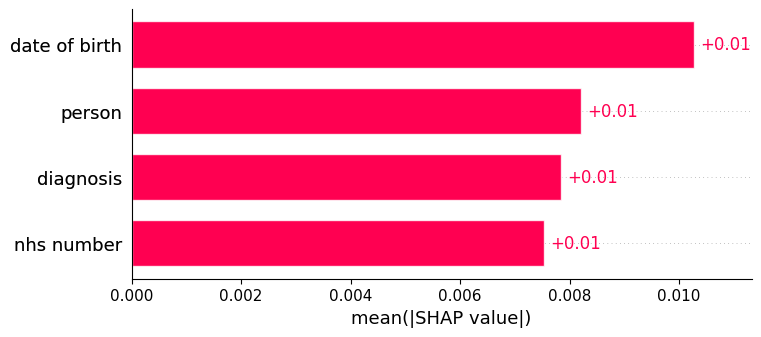

In [11]:
# Plot the mean shap values - global explanation
explainer.plot_global_explanation(exp_obj)

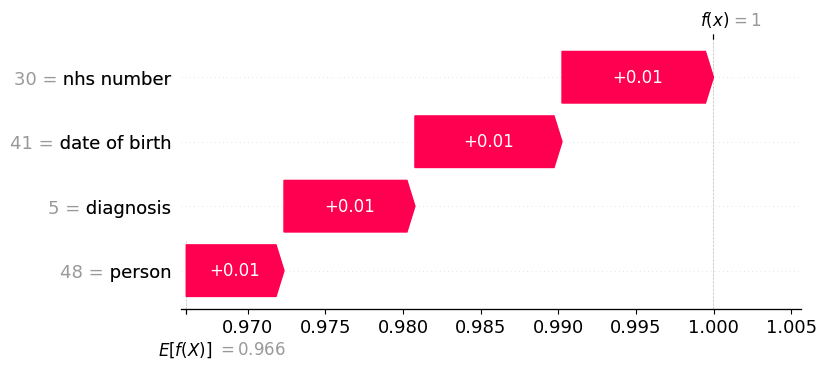

In [12]:
# Plot the local shap values for a particular record
explainer.plot_local_explanation(exp_obj, 49)